## Background

The intent of this analysis is to determine the correlation between the verbosity of wine descriptions and the price points for the wine.  

This analysis uses the [Wine Dataset](https://www.kaggle.com/datasets/elvinrustam/wine-dataset) provided by the user Elvin Rustamov on Kaggle. The dataset offers basic details on different wine types sold in Europe.

### Variables

There are 17 variables provided in the original dataset:
* **Title**: The name of the name, occasionally includes the winemaker and year.
* **Description**: The summary description usually found on the wine lable
* **Price**: The retail price of the wine in pounds (£)
* **Capacity**: The volume or size of the wine bottle in metric units
* **Grape**: The primary grape variety used in making the wine
* **Secondary Grape Varieties**: Any additional grape varieties used
* **Closure**: How the bottle is sealed
* **Country**: Where the wine is produced
* **Unit**: Unknown factor, not described in the user's documentation and unclear based on context
* **Characteristics**: Tasting notes focused on flavor
* **Per bottle / case / each**: If the wine is sold by the case, bottle, etc.
* **Type**: The general wine category (e.g. red, white, etc)
* **ABV**: Alcohol content in the wine
* **Region**: Where the grapes are grown
* **Style**: Tasting notes, focused on the sensory experience
* **Vintage**: The growing year for the grapes used
* **Appellation**: The legally defined growing region for the grapes

## Setup

In [431]:
#set working directory and mount Google Drive
import os
os.getcwd( )
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [432]:
#import needed packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Initial Review & Cleaning

In [433]:
#read in dataset, ID variables
df = pd.read_csv('/content/drive/MyDrive/Portfolio/data/WineDataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Title                      1290 non-null   object 
 1   Description                1286 non-null   object 
 2   Price                      1290 non-null   object 
 3   Capacity                   1290 non-null   object 
 4   Grape                      1275 non-null   object 
 5   Secondary Grape Varieties  488 non-null    object 
 6   Closure                    1279 non-null   object 
 7   Country                    1284 non-null   object 
 8   Unit                       1281 non-null   float64
 9   Characteristics            1253 non-null   object 
 10  Per bottle / case / each   1290 non-null   object 
 11  Type                       1285 non-null   object 
 12  ABV                        1281 non-null   object 
 13  Region                     1124 non-null   objec

In [434]:
#check content in variables
df.head()

,Title,Description,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage,Appellation
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,£9.99 per bottle,75CL,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,ABV 14.00%,NaN,Rich & Juicy,NV,NaN
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,£15.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,ABV 13.50%,California,Rich & Toasty,2021,Napa Valley
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,£12.49 per bottle,75CL,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,ABV 13.00%,Marlborough,Crisp & Zesty,2022,NaN
3,Louis Latour Mâcon-Lugny 2021/22,We’ve sold this wine for thirty years – and fo...,£17.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,France,10.1,"Peach, Apricot, Floral, Lemon",per bottle,White,ABV 13.50%,Burgundy,Ripe & Rounded,2022,Macon
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,£15.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",per bottle,Red,ABV 13.50%,California,Smooth & Mellow,2021,Napa Valley


In [435]:
#check capacity values to assist with cleaning
df['Capacity'].value_counts()

75CL      1193
37.5CL      23
750ML       18
1.5LTR      18
150CL       11
50CL         8
Our          6
2.25L        4
70CL         3
500ML        3
300CL        1
5LITRE       1
375ML        1
Name: Capacity, dtype: int64

In [436]:
#remove non-standard bottle sizes
standard = ['75CL', '750ML']
df = df[df['Capacity'].isin(standard)]

#confirm change
df['Capacity'].value_counts()

75CL     1193
750ML      18
Name: Capacity, dtype: int64

In [437]:
#confirm prices are all in £
df[~df['Price'].str.contains('£')]

,Title,Description,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage,Appellation


## New dataframe setup

In [438]:
#establish new dataframe
d = pd.DataFrame()

#separate price and unit
d['Price'] = df['Price'].str.extract('([0-9]+\.[0-9]{2})').astype(np.float64)
d['Price_per'] = df['Price'].str.extract('((?<=per).*$)')

#ID descriptors of concern for analysis
descriptor = ['Description', 'Characteristics', 'Style']

#develop counts in descriptors of concern
for i in descriptor:
  d[i+'_char'] = df[i].str.len()
  d[i+'_words'] = df[i].str.split().str.len()

counts = ['_char', '_words']

for x in counts:
  d['Total'+x] = d['Description'+x] + d['Characteristics'+x] + d['Style'+x]

d.head()

,Price,Price_per,Description_char,Description_words,Characteristics_char,Characteristics_words,Style_char,Style_words,Total_char,Total_words
0,9.99,bottle,481.0,78.0,33.0,3.0,12.0,3.0,526.0,84.0
1,15.99,bottle,544.0,94.0,68.0,9.0,13.0,3.0,625.0,106.0
2,12.49,bottle,664.0,112.0,78.0,10.0,13.0,3.0,755.0,125.0
3,17.99,bottle,647.0,112.0,29.0,4.0,14.0,3.0,690.0,119.0
4,15.99,bottle,793.0,128.0,48.0,7.0,15.0,3.0,856.0,138.0


## Clean new dataframe

In [439]:
#check overarching size of dataframe d
d.shape

(1211, 10)

In [440]:
#check count of rows with null values in descriptors of concern
null_mask = d.isna().any(axis=1)
len(d[null_mask])

54

In [441]:
#drop null values if minimal impact
d = d.dropna()

#verify no null values
null_mask = d.isna().any(axis=1)
len(d[null_mask])

0

In [442]:
#change counts to integer
d[d.columns[2:]] = d[d.columns[2:]].astype(int)

#verify update
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1157 entries, 0 to 1289
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  1157 non-null   float64
 1   Price_per              1157 non-null   object 
 2   Description_char       1157 non-null   int64  
 3   Description_words      1157 non-null   int64  
 4   Characteristics_char   1157 non-null   int64  
 5   Characteristics_words  1157 non-null   int64  
 6   Style_char             1157 non-null   int64  
 7   Style_words            1157 non-null   int64  
 8   Total_char             1157 non-null   int64  
 9   Total_words            1157 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 99.4+ KB


In [443]:
#check unique values in each column
d.apply(pd.Series.nunique)

Price                    110
Price_per                  1
Description_char         555
Description_words        145
Characteristics_char      87
Characteristics_words     12
Style_char                 8
Style_words                2
Total_char               562
Total_words              149
dtype: int64

In [444]:
#drop minimally impactful values, verify
d = d.drop(['Price_per', 'Style_words'], axis = 1)
d.apply(pd.Series.nunique)

Price                    110
Description_char         555
Description_words        145
Characteristics_char      87
Characteristics_words     12
Style_char                 8
Total_char               562
Total_words              149
dtype: int64

In [445]:
#review numerical data for anomalies
for col in list(d.select_dtypes(include=['int', 'float']).columns):
  print('Details for',col,
        '\n  Min:',d[col].min(),
        '\n  Max:',d[col].max(),
        '\n  Median:',d[col].median().round(),
        '\n  Mean:',d[col].mean().round(),'\n'
        )

Details for Price 
  Min: 4.99 
  Max: 430.0 
  Median: 17.0 
  Mean: 28.0 

Details for Description_char 
  Min: 85 
  Max: 1328 
  Median: 504.0 
  Mean: 521.0 

Details for Description_words 
  Min: 15 
  Max: 212 
  Median: 84.0 
  Mean: 86.0 

Details for Characteristics_char 
  Min: 18 
  Max: 117 
  Median: 38.0 
  Mean: 41.0 

Details for Characteristics_words 
  Min: 3 
  Max: 14 
  Median: 5.0 
  Mean: 6.0 

Details for Style_char 
  Min: 12 
  Max: 21 
  Median: 14.0 
  Mean: 15.0 

Details for Total_char 
  Min: 133 
  Max: 1382 
  Median: 560.0 
  Mean: 577.0 

Details for Total_words 
  Min: 23 
  Max: 221 
  Median: 93.0 
  Mean: 95.0 



<Axes: xlabel='Price'>

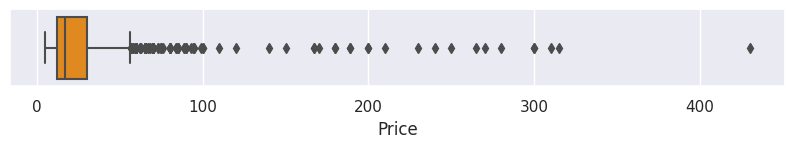

In [446]:
#display boxplot for Price
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Price'], color='darkorange')

In [447]:
#Top values for Price to determine minimal impact cutoff
top = d.query('Price > 75')
print('Min Outlier Values:',top['Price'].min(),
      '\nMax Outlier Values:',top['Price'].max(),
      '\nCount of values:',len(top.index))

Min Outlier Values: 75.99 
Max Outlier Values: 430.0 
Count of values: 50


<Axes: xlabel='Price'>

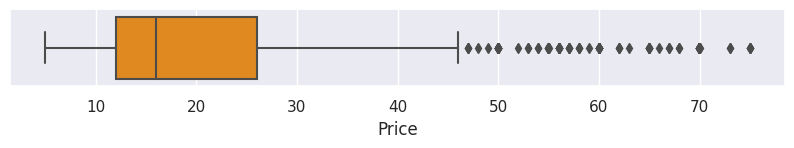

In [448]:
#After determining minimal impact cutof, remove outliers
d = d.query('Price < 75')

#display updated boxplot
plt.figure(figsize=(10,1))
sns.boxplot(x=d['Price'], color='darkorange')

## Data Analysis

In [449]:
#review correlation between target and features
d.corr()['Price'].sort_values().round(2)

Description_words       -0.09
Description_char        -0.08
Total_words             -0.07
Total_char              -0.06
Style_char               0.11
Characteristics_words    0.14
Characteristics_char     0.15
Price                    1.00
Name: Price, dtype: float64

In [453]:
#FIX THIS!!!! BROKEN
#set target and predictors to continue feature selection
columns = list(d.columns)
pred_vars = list(d.columns[1:])

y = d['Price']
X = d[pred_vars]

#manual feature selection
vif = pd.DataFrame()
vif['Predictor'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i)
  for i in range(X.shape[1])]

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:



cr = d.corr()['Price'].round(3)
vif['Relevance'] = [cr[i]
  for i in range(X.shape[1])]
vif

In [ ]:
#check for intercorrelation between features
sns.set(rc={"figure.figsize":(7, 5)})
sns.heatmap(d.corr().round(2), linewidths=2.0,
            annot=True, annot_kws={"size": 10},
            cmap=sns.dark_palette("darkorange")
            )

In [399]:
d.columns[1:]

Index(['Description_char', 'Description_words', 'Characteristics_char',
       'Characteristics_words', 'Style_char', 'Total_char', 'Total_words'],
      dtype='object')